In [122]:
import pandas as pd
import sqlite3

con = sqlite3.connect("SoccerDataset/database.sqlite")

# Load the data into a DataFrame
inner = 'SELECT player_api_id, MAX(date) as date FROM player_attributes GROUP BY player_api_id'
player_df = pd.read_sql_query('SELECT * from Player p INNER JOIN ('+ inner +') Sub1 ON p.player_api_id = Sub1.player_api_id INNER JOIN player_attributes ON player_attributes.player_api_id = Sub1.player_api_id AND player_attributes.date = Sub1.date', con)

con.close()

In [123]:
player_df

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,505942,2016-02-18 00:00:00,1,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146,155782,2016-04-21 00:00:00,6,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163,162549,2016-01-07 00:00:00,39,...,68.0,61.0,23.0,22.0,24.0,16.0,11.0,12.0,9.0,13.0
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198,30572,2016-04-21 00:00:00,65,...,54.0,37.0,72.0,71.0,68.0,15.0,12.0,13.0,12.0,11.0
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154,23780,2015-12-24 00:00:00,88,...,41.0,45.0,75.0,73.0,71.0,8.0,6.0,16.0,12.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168,26357,2015-03-06 00:00:00,183925,...,52.0,50.0,76.0,77.0,72.0,14.0,10.0,11.0,8.0,12.0
11060,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176,111182,2014-09-18 00:00:00,183938,...,49.0,53.0,57.0,61.0,61.0,9.0,8.0,5.0,5.0,8.0
11061,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154,36491,2011-02-22 00:00:00,183954,...,66.0,61.0,67.0,71.0,59.0,15.0,13.0,5.0,6.0,6.0
11062,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172,35506,2011-02-22 00:00:00,183961,...,63.0,45.0,65.0,66.0,65.0,14.0,7.0,15.0,10.0,12.0


In [124]:
df_one_hot_list = ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate']

def prepare_dataframe(df):
    df = df[df.defensive_work_rate.isin(['low', 'medium', 'high'])]
    df = pd.concat([df, pd.get_dummies(df['defensive_work_rate'], prefix='defensive_work_rate')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['preferred_foot'], prefix='preferred_foot')],axis=1)
    df = df[df.attacking_work_rate.isin(['low', 'medium', 'high'])]
    df = pd.concat([df, pd.get_dummies(df['attacking_work_rate'], prefix='attacking_work_rate')],axis=1)
    df = df.drop(df_one_hot_list, axis=1)
    return df

player_df = prepare_dataframe(player_df)

In [125]:
# Ok IDEE: Neue Daten generieren OHNE die Verwendung von GANs. Dazu erstelle ich Buckets (n-Viele) und gebe die percentiles wieder. 

def get_col_quantile(df, col, buckets):
    step = 1 / buckets
    container = []
    
    for i in range(buckets):
        container.append(df[col].quantile(step * i))
    
    return container

quantile = get_col_quantile(player_df, 'overall_rating', 10)
quantile

[47.0, 61.0, 63.0, 65.0, 66.0, 68.0, 70.0, 72.0, 74.0, 76.0]

In [126]:
print([player_df['overall_rating'].mean(), player_df['overall_rating'].max(), player_df['overall_rating'].min(), player_df['overall_rating'].std()])

[68.27505803976986, 94.0, 47.0, 6.282576855113117]


In [127]:
def split_df_in_buckets(df, col, buckets):
    split = df.shape[0] / buckets
    container = []
    
    for i in range(buckets):
        container.append(df.sort_values(by=[col])[int(i*split):int((i+1)*split)])
        
    return container

In [128]:
buckets = split_df_in_buckets(player_df, 'overall_rating', 10)
buckets[1]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,player_api_id,date,id,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
3023,3027,177843,Enes Sipovic,226628,1990-09-11 00:00:00,198.12,203,177843,2015-05-15 00:00:00,50485,...,11.0,9.0,0,0,1,0,1,0,0,1
9228,9238,301241,Ross Barbour,212907,1993-02-01 00:00:00,177.80,157,301241,2016-03-10 00:00:00,153755,...,16.0,11.0,0,0,1,0,1,0,0,1
1299,1302,89548,Bojan Bozovic,164407,1985-02-03 00:00:00,190.50,185,89548,2015-07-03 00:00:00,22037,...,14.0,13.0,0,0,1,0,1,1,0,0
7391,7401,192679,Michael Tidser,213460,1990-01-15 00:00:00,182.88,168,192679,2015-01-09 00:00:00,123822,...,8.0,13.0,0,0,1,1,0,1,0,0
6849,6858,32658,Mark Brown,45162,1981-02-28 00:00:00,185.42,172,32658,2014-12-05 00:00:00,114391,...,60.0,60.0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10966,10978,26674,Youssef El Akchaoui,109809,1981-02-18 00:00:00,175.26,159,26674,2012-08-31 00:00:00,182524,...,10.0,12.0,0,0,1,1,0,0,0,1
9600,9611,68827,Sebastian Ziajka,204145,1982-12-15 00:00:00,182.88,165,68827,2016-05-05 00:00:00,159873,...,15.0,9.0,0,1,0,1,0,1,0,0
992,995,173983,Arthur,192038,1987-01-14 00:00:00,177.80,150,173983,2016-03-24 00:00:00,17121,...,6.0,13.0,0,0,1,1,0,1,0,0
9598,9609,299021,Sebastian Steblecki,208907,1992-01-16 00:00:00,185.42,154,299021,2016-03-03 00:00:00,159845,...,7.0,16.0,0,0,1,0,1,1,0,0


In [129]:
for df in buckets:
    print(df['overall_rating'].mean())
    print(df['overall_rating'].std())

57.41818181818182
2.6908211441868066
61.98789101917255
0.7887175962897163
64.0100908173562
0.6371488669161706
65.58484848484848
0.4929971966119816
67.27547931382442
0.508308888956166
68.85671039354187
0.6127046150767197
70.62525252525252
0.591453016089472
72.63471241170535
0.6290652782344168
74.91422805247225
0.795002944191316
79.43188698284561
2.633343377683589


In [130]:
player_df.dtypes

id                              int64
player_api_id                   int64
player_name                    object
player_fifa_api_id              int64
birthday                       object
height                        float64
weight                          int64
player_api_id                   int64
date                           object
id                              int64
player_fifa_api_id              int64
player_api_id                   int64
date                           object
overall_rating                float64
potential                     float64
crossing                      float64
finishing                     float64
heading_accuracy              float64
short_passing                 float64
volleys                       float64
dribbling                     float64
curve                         float64
free_kick_accuracy            float64
long_passing                  float64
ball_control                  float64
acceleration                  float64
sprint_speed

In [131]:
import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors
import pandas as pd
#referring to https://stats.stackexchange.com/questions/215938/generate-synthetic-data-to-match-sample-data

df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
column_names = list(df.columns)

def SMOTE(T, N, k):
# """
# Returns (N/100) * n_minority_samples synthetic minority samples.
#
# Parameters
# ----------
# T : array-like, shape = [n_minority_samples, n_features]
#     Holds the minority samples
# N : percetange of new synthetic samples:
#     n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
# k : int. Number of nearest neighbours.
#
# Returns
# -------
# S : array, shape = [(N/100) * n_minority_samples, n_features]
# """
    n_minority_samples, n_features = T.shape

    if N < 100:
       #create synthetic samples only for a subset of T.
       #TODO: select random minortiy samples
       N = 100
       pass

    if (N % 100) != 0:
       raise ValueError("N must be < 100 or multiple of 100")

    N = N/100
    n_synthetic_samples = N * n_minority_samples
    n_synthetic_samples = int(n_synthetic_samples)
    n_features = int(n_features)
    S = np.zeros(shape=(n_synthetic_samples, n_features))

    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)

    #Calculate synthetic samples
    for i in range(n_minority_samples):
        nn = neigh.kneighbors(T[i].reshape(1, -1), return_distance=False)
        for n in range(int(N)):
            nn_index = choice(nn[0]) #Take one of the nearest neighbour
            #NOTE: nn includes T[i], we don't want to select it
            while nn_index == i:
                nn_index = choice(nn[0])

            dif = T[nn_index] - T[i] # calculates the difference between current and neighbour
            gap = np.random.random() # bring some randomness to the mix
            S[int(n + i * N), :] = T[i,:] + gap * dif[:] # set the new data
    return S

df = df.to_numpy()
new_data = SMOTE(df,50,10) # this is where I call the function and expect new_data to be generated with larger number of samples than original df.
new_data.shape

(9907, 43)

In [132]:
new_df = pd.DataFrame(new_data, columns=column_names)

In [133]:
def laplaceMechanism(x, epsilon):
    x += np.random.laplace(0, 1.0/epsilon, 1)[0]
    return x

for col in column_names:
    new_df[col] = new_df[col].apply(laplaceMechanism, args=(2,))

In [134]:
def compare_two_dataframe(df1, df2, col_names, buckets = 10):
    res = []
    dif_total = 0
    
    for col in col_names:
        q1 = get_col_quantile(df1, col, buckets)
        q2 = get_col_quantile(df2, col, buckets)
        
        dif = []
        for i in range(buckets):
            dif.append(q1[i] - q2[i])
            
        percent = 1
        if sum(q1) > sum(q2):
            percent = sum(q2) / sum(q1)
        elif sum(q1) < sum(q2):
            percent = sum(q1) / sum(q2)
            
        dif_total += sum(dif)
        entry = {
            'name': col,
            'q1': q1,
            'q2': q2,
            'dif': dif,
            'dif_total': sum(dif),
            'percent': percent,
        }
        #res.append(entry)
        res.append(percent)
        
    return (res, dif_total)

In [135]:
res, dif_total = compare_two_dataframe(new_df, player_df, column_names, 100)
dif_total

190.59526098182246

In [136]:
import matplotlib.pyplot as plt

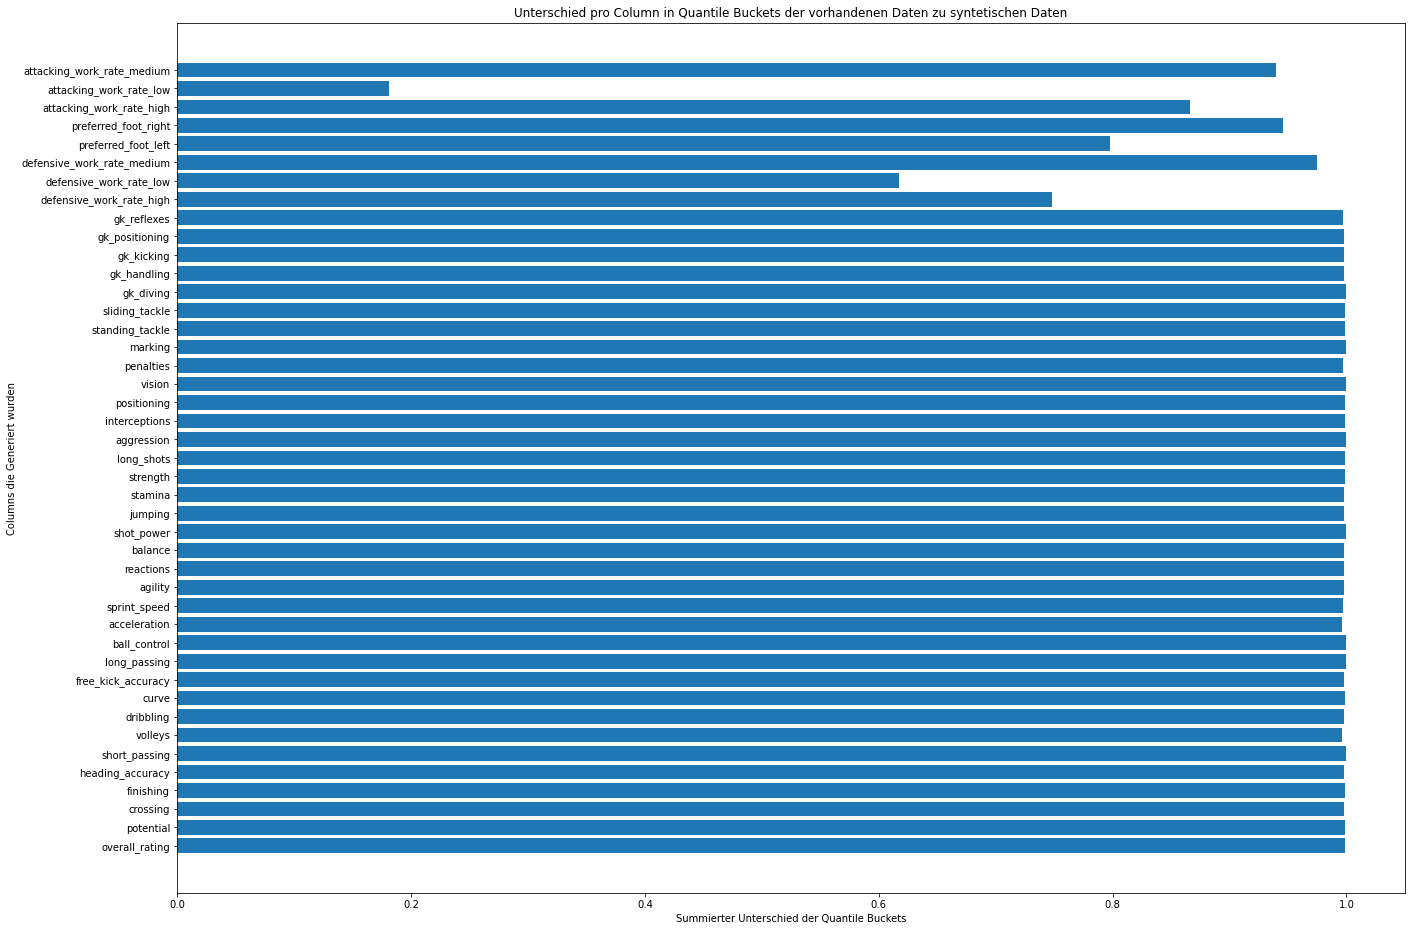

In [137]:
plt.figure(figsize=(22,16))
plt.barh(column_names, res)
plt.title('Unterschied pro Column in Quantile Buckets der vorhandenen Daten zu syntetischen Daten')
plt.xlabel('Summierter Unterschied der Quantile Buckets')
plt.ylabel('Columns die Generiert wurden')
plt.show()

In [138]:
print(f'Overall accuracy: {sum(res) / len(res)}')

Overall accuracy: 0.9537764046262363


In [139]:
new_df[new_df.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
5534,92.879124,91.679762,80.425299,89.45643,65.826541,87.058686,85.11597,95.076527,88.475882,87.371991,...,10.673912,10.22619,0.923331,1.805701,0.437966,1.923833,-0.557064,0.090701,-1.406917,0.690871


In [140]:
df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
df[df.overall_rating > 90]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
1992,93.0,93.0,82.0,95.0,86.0,81.0,87.0,93.0,88.0,77.0,...,14.0,11.0,0,1,0,0,1,1,0,0
6170,94.0,94.0,80.0,93.0,71.0,88.0,85.0,96.0,89.0,90.0,...,14.0,8.0,0,1,0,1,0,0,0,1


In [141]:
# Ich versuche jetzt, ein Generator Modell zu erstellen welches mir neue Daten anhand eines Noise Vektors generiert. 
# Der Generator selbst hat die Original Daten nie gesehen, er nimmt einfach nur Random entgegen und basierend darauf erstellt er etwas. 
# Wie gut das Ergebnis ist, bestimmt später der Discriminator, den ich vermutlich erst später implementiere.

# Zu beginn ist das Ziel, ein super einfachen Generator zu erstellen, der mir basierend auf die eingehende Anzahl an spalten "random" Ausgaben erzeugt. Logischerweise noch super random da 0 trainiert

In [142]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# Warum auch immer, bekomme ich einen fehler wenn ich das hier nicht drinne habe. 
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.90
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

E:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [143]:
def make_generator_model(df):
    # Ich übernehme zu beginn, den Anfang des Generators aus dem Bild Generator
    model = tf.keras.Sequential()
    model.add(layers.Dense(df.shape[1] * 256, use_bias = False, input_shape=(100, ))) # Random Noise Vektor mal wieder 100 Dim als Input
    # model.add(layers.BatchNormalization()) # BN macht man meist nur bei CNNs..
    model.add(layers.LeakyReLU())
    
    #model.add(layers.Reshape((7, 7, 256)))
    #assert model.output_shape == (None, 7, 7, 256) # => None ist batch size, rest ist der Shape den wir haben wollen
    
    #model.add(layers.Flatten())
    model.add(layers.Dense(256, use_bias = False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(128, use_bias = False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(df.shape[1], use_bias = False))
    
    return model

In [144]:
train_df = player_df.loc[:, 'overall_rating':'attacking_work_rate_medium']
generator = make_generator_model(train_df)

noise = tf.random.normal([1, 100])

generated_data = generator(noise, training=False)
generated_data

<tf.Tensor: shape=(1, 43), dtype=float32, numpy=
array([[ 0.07514141, -0.11023273,  0.00579892,  0.06462046,  0.2179451 ,
        -0.09043551, -0.03423711,  0.06400489,  0.09259926, -0.10456073,
        -0.0118721 , -0.09897947, -0.01589028,  0.03002398,  0.03747174,
        -0.01036361, -0.06445894, -0.01600901, -0.1739492 ,  0.02546685,
        -0.22904797,  0.04549012, -0.14291757, -0.15221725,  0.21983482,
        -0.11691906,  0.05874269,  0.15417677, -0.10457525, -0.06311091,
         0.03326471,  0.04593906,  0.07627081,  0.08307135, -0.03076698,
        -0.0062488 ,  0.0432673 , -0.14372581, -0.11735564,  0.01509774,
         0.0830503 , -0.0383027 , -0.08329543]], dtype=float32)>

In [145]:
def make_discriminator_model(df):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [146]:
discriminator = make_discriminator_model(train_df)
decision = discriminator(generated_data)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04010409]], dtype=float32)>

In [147]:
# Cookie Cutter aus dem DCGAN Notebook

In [148]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

lerning_rate = 0.0001
generator_optimizer = tf.keras.optimizers.Adam(lerning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(lerning_rate)

checkpoint_dir = './checkpoints/dcgan_soccer_2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [149]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [150]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        #if (epoch +1) % 199 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    display.clear_output(wait=True)
    #generate_and_save_images(generator, epoch + 1, seed)

In [151]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    print(predictions.shape)

In [152]:
from sklearn import preprocessing

x = train_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_train_df = pd.DataFrame(x_scaled)

In [153]:
BUFFER_SIZE = 9907
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_train_df).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [154]:
train(train_dataset, EPOCHS * 100)

(16, 43)
Time for epoch 5000 is 0.12566328048706055 sec


In [156]:
noise = tf.random.normal([9907, 100])

generated_data = generator(noise, training=False)
generated_data = min_max_scaler.inverse_transform(generated_data)

In [157]:
gan_df = pd.DataFrame(data=generated_data, columns=column_names).astype("float")

34463.85746501457
Overall accuracy: 0.7553617370759609


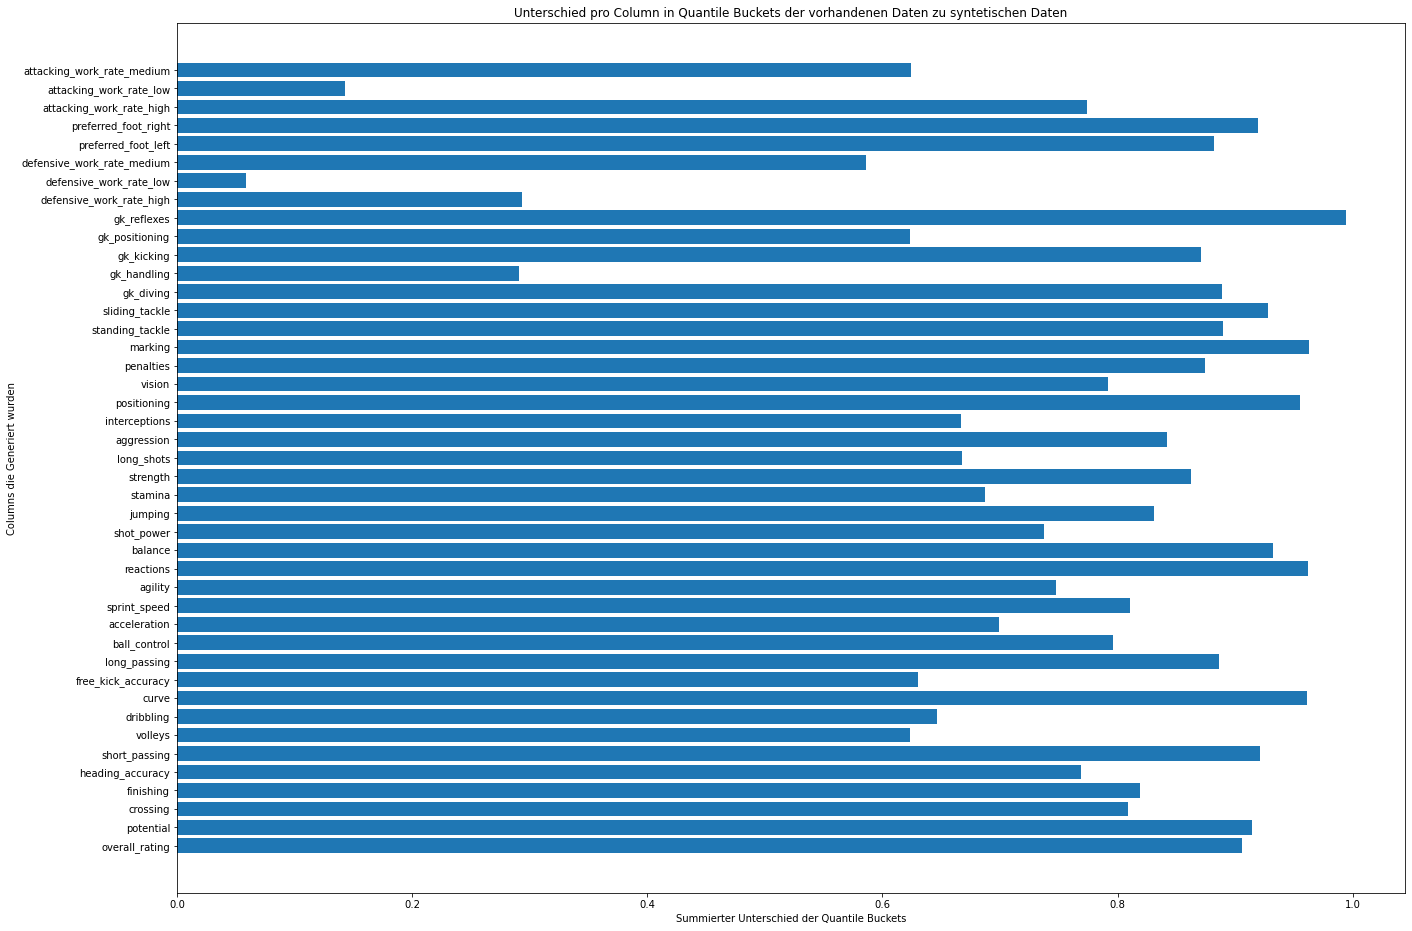

In [158]:
res, dif_total = compare_two_dataframe(gan_df, train_df, column_names, 100)
print(dif_total)
print(f'Overall accuracy: {sum(res) / len(res)}')
plt.figure(figsize=(22,16))
plt.barh(column_names, res)
plt.title('Unterschied pro Column in Quantile Buckets der vorhandenen Daten zu syntetischen Daten')
plt.xlabel('Summierter Unterschied der Quantile Buckets')
plt.ylabel('Columns die Generiert wurden')
plt.show()

In [159]:
gan_df

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
0,80.299045,76.554164,46.550239,20.486555,90.525449,54.705267,48.603225,65.185603,27.287377,29.191648,...,15.966991,12.855555,0.007365,0.009671,1.087653,-0.005937,1.134165,-0.011406,1.129470,-0.004881
1,73.501106,79.592804,74.759418,76.091515,72.103589,71.545808,87.896958,92.734239,70.637552,87.495058,...,9.628046,18.446267,-0.002417,0.005468,0.997711,1.030059,-0.013750,-0.002262,0.017010,1.035283
2,75.669029,79.664231,71.245310,51.732551,68.232116,66.816872,75.584141,87.660250,53.954714,81.059785,...,8.523703,15.450712,0.873043,0.009082,0.046984,0.946677,-0.009147,0.014361,-0.000614,0.940244
3,75.328264,77.026528,72.728251,61.274548,68.730085,69.818607,83.883679,96.103726,61.180330,86.047540,...,7.219941,13.234584,0.880199,0.009088,-0.006744,0.160083,0.731660,-0.000635,0.016400,0.905379
4,79.202892,77.958550,62.768624,43.320634,83.938028,62.740792,76.890825,85.672036,50.711833,77.665723,...,10.925976,14.281958,0.959818,0.010302,0.006379,0.017578,0.995777,0.006787,0.982910,0.005170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9902,72.331853,77.134833,76.398165,77.519218,61.455558,70.569184,85.565443,104.345457,65.715348,87.734880,...,7.478052,16.088119,0.004134,0.002712,0.929518,0.675647,0.271201,0.000464,0.006137,0.947999
9903,68.441337,72.967343,67.193638,64.634304,56.678935,62.374344,73.242659,84.372989,58.814185,73.791400,...,7.466580,14.991188,0.000958,-0.001065,0.860654,0.180572,0.680608,-0.000859,0.008406,0.874749
9904,76.916898,75.585219,74.048914,56.419996,81.750461,72.771696,84.869048,89.118230,65.607024,88.939466,...,10.679579,15.270436,0.414312,0.012025,0.604681,-0.001276,1.092606,0.002945,1.063595,0.019133
9905,79.509784,77.107305,53.346689,26.077026,88.227229,58.463005,57.265849,67.389858,36.752460,44.561223,...,15.605948,14.208110,-0.022722,0.018386,1.125212,0.012713,1.140805,-0.012265,1.128311,-0.002190


In [166]:
gan_df[gan_df.overall_rating > 80]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
0,80.299045,76.554164,46.550239,20.486555,90.525449,54.705267,48.603225,65.185603,27.287377,29.191648,...,15.966991,12.855555,0.007365,0.009671,1.087653,-0.005937,1.134165,-0.011406,1.129470,-0.004881
13,81.882544,85.105690,79.992572,67.360110,78.522507,80.993646,96.798146,106.204700,66.334629,95.954000,...,7.875549,13.425157,0.988870,0.012830,0.060378,0.012663,1.046704,0.115055,0.010954,0.948240
14,84.412306,83.206595,93.755901,85.426177,90.819333,87.980610,110.642516,123.859075,74.402615,125.283065,...,10.096762,18.093814,1.129187,0.009169,0.018416,0.162039,1.007303,0.424840,0.722406,0.035296
23,80.260713,81.665363,75.196994,61.111974,82.500956,71.747445,78.396434,101.839974,54.230838,83.172416,...,9.027443,16.164489,1.058967,0.009164,-0.012277,1.046449,0.017526,0.481343,0.591384,-0.005259
26,80.973926,84.354927,76.851626,81.155907,74.853510,76.503852,93.687665,109.345127,65.991078,98.153562,...,8.421106,15.245968,0.964123,-0.000788,0.024411,0.015854,0.993739,0.996646,0.007270,0.004437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9833,80.962451,83.088758,78.069881,78.632136,80.659201,78.298696,92.752203,105.670308,66.281039,95.990457,...,10.247325,17.177782,0.986145,0.008433,0.023005,0.204235,0.841752,0.970183,0.006940,0.064897
9836,83.793436,86.352191,85.378952,80.839701,81.213630,85.292809,103.726746,117.011331,72.701652,108.892000,...,9.933185,15.971834,1.069126,0.001798,0.028044,-0.019592,1.136980,0.680493,0.017363,0.417620
9853,84.596835,86.845975,87.166480,67.259725,94.109059,82.205142,89.950940,113.550799,57.713017,94.595826,...,8.439152,17.363673,1.053947,0.005547,0.063340,1.136965,-0.001173,1.051010,0.016672,0.075613
9881,80.640120,83.050539,72.829049,69.395128,76.757620,74.557709,85.855718,111.681878,58.459273,96.338457,...,8.100469,14.743172,0.917940,0.011109,0.054698,0.606381,0.379743,0.998861,-0.003051,0.009218


In [168]:
train_df[train_df.overall_rating > 80]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_positioning,gk_reflexes,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,preferred_foot_left,preferred_foot_right,attacking_work_rate_high,attacking_work_rate_low,attacking_work_rate_medium
14,82.0,85.0,75.0,75.0,58.0,83.0,79.0,81.0,70.0,70.0,...,10.0,8.0,1,0,0,0,1,1,0,0
55,82.0,82.0,75.0,72.0,77.0,73.0,69.0,86.0,69.0,57.0,...,7.0,15.0,0,0,1,0,1,0,0,1
429,82.0,85.0,86.0,59.0,64.0,77.0,61.0,82.0,73.0,59.0,...,12.0,5.0,0,0,1,1,0,1,0,0
479,83.0,87.0,70.0,86.0,76.0,80.0,82.0,85.0,74.0,73.0,...,5.0,6.0,1,0,0,0,1,1,0,0
498,86.0,87.0,77.0,83.0,65.0,79.0,78.0,88.0,78.0,78.0,...,12.0,13.0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10867,82.0,84.0,72.0,72.0,46.0,79.0,74.0,92.0,84.0,78.0,...,7.0,7.0,0,0,1,0,1,0,0,1
10880,82.0,83.0,13.0,13.0,10.0,40.0,8.0,15.0,12.0,13.0,...,76.0,86.0,0,0,1,0,1,0,0,1
10911,85.0,85.0,67.0,82.0,74.0,86.0,68.0,81.0,80.0,85.0,...,12.0,8.0,0,1,0,0,1,0,0,1
10916,82.0,84.0,77.0,79.0,49.0,81.0,67.0,86.0,83.0,77.0,...,9.0,9.0,0,0,1,0,1,0,0,1


In [162]:
# undo, nur ein quick work arround da fehler oben:
df_one_hot_list = ['defensive_work_rate', 'preferred_foot', 'attacking_work_rate']

# pd.get_dummies(s).idxmax(1)

def unsolve_one_hot(df, hot_cols):
    copy = df.copy()
    for col in hot_cols:
        loop_cols = df.filter(like=col).columns
        res = df[loop_cols].max(1)        
        copy[col] = pd.get_dummies(df[loop_cols]).idxmax(1).map(lambda x: x.lstrip(col).lstrip('_'))
        copy = copy.drop(loop_cols, axis=1)
    
    return copy
                

In [163]:
encoded = unsolve_one_hot(gan_df, df_one_hot_list)
encoded[encoded.preferred_foot == 'left']

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,defensive_work_rate,preferred_foot,attacking_work_rate
1,73.501106,79.592804,74.759418,76.091515,72.103589,71.545808,87.896958,92.734239,70.637552,87.495058,...,51.845214,44.549215,13.921986,3.418675,13.372521,9.628046,18.446267,medium,left,medium
2,75.669029,79.664231,71.245310,51.732551,68.232116,66.816872,75.584141,87.660250,53.954714,81.059785,...,60.219752,55.217267,12.018046,2.812722,12.446310,8.523703,15.450712,high,left,medium
5,72.847689,77.916523,78.051546,76.154488,59.932003,74.467932,85.377169,100.245669,73.533216,99.695360,...,41.762356,34.507207,15.043842,2.601418,14.043702,7.998774,18.527699,medium,left,medium
12,74.529644,77.388473,67.090098,62.320749,75.080842,65.731069,68.655385,88.813037,45.073988,68.944692,...,49.465037,48.082202,10.001529,4.279010,7.140143,7.397775,15.914265,high,left,high
18,70.953987,75.578449,60.321851,64.810155,60.362294,63.131115,60.910250,88.870785,49.398207,70.180187,...,45.828685,43.391992,9.513681,1.414447,7.821057,6.082833,15.835911,medium,left,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9888,69.716418,72.720571,65.383894,60.270168,54.544198,61.201559,69.028852,85.304295,54.567024,72.853786,...,43.175371,39.670864,10.650125,2.687288,9.967661,5.185589,13.674411,medium,left,medium
9891,79.449669,81.372632,71.316946,51.809965,86.869748,69.584377,77.068893,92.840749,50.990956,79.148963,...,68.300834,68.006136,13.891746,5.102180,11.089137,9.958837,17.094623,high,left,low
9899,77.527969,81.399524,77.405331,73.416071,73.499958,76.951117,79.678911,93.911021,72.161647,94.044503,...,62.427205,57.510920,14.108567,6.269267,8.450727,8.290379,16.976972,medium,left,high
9901,77.697152,83.021480,80.741388,77.753793,73.042376,81.747928,79.090107,105.718813,70.787287,99.179785,...,62.610533,57.429183,13.688451,4.996611,10.735739,8.332709,20.160373,medium,left,high


In [92]:
# Ok, das Ziel ist es jetzt, die Spieler Tabelle zu generieren.

#1.) Laden der OG Daten:
con = sqlite3.connect("SoccerDataset/database.sqlite")
player_train_df = pd.read_sql_query('SELECT * from Player', con)
con.close()

In [94]:
#2.) One-Hot Encoden von Spalten. Bei den Spielern nicht nötigt, da es keine Attrs. gibt
#3.) Vorbereiten anderer Datentypen, die Generiert werden sollen. Hier z.B. Geburtsdatum
player_train_df['birthday'] = pd.to_datetime(player_train_df['birthday'])
player_train_df['birthday'] = player_train_df.birthday.values.astype(np.int64) // 10 ** 9

In [97]:
#4.) DF erstellen, über Daten die generiert werden sollen. Hier ist es relativ einfach 
training_cols = ['birthday', 'height', 'weight']
training_df = player_train_df[training_cols]

,birthday,height,weight
0,699321600,182.88,187
1,629683200,170.18,146
2,674092800,170.18,163
3,389664000,182.88,198
4,310867200,182.88,154
...,...,...,...
11055,291945600,182.88,168
11056,535248000,182.88,176
11057,294192000,180.34,154
11058,371174400,185.42,172


In [98]:
#5.) Normalizieren der Daten, hier mal ein versuch mit SKLearn vll kann man es damit dann auch besser rückgängig machen:
from sklearn import preprocessing

x = training_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
norm_df = pd.DataFrame(x_scaled)

In [104]:
#6.) Erstellen der benötigten Modelle, ich versuche es so zu machen, dass "ein" Modell für alle Situationen erstellt werden kann. Aber es muss immer neu trainiert werden...
generator = make_generator_model(norm_df)
discriminator = make_discriminator_model(norm_df)

BUFFER_SIZE = 11060
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(norm_df).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [109]:
#7.) Magic
train(train_dataset, EPOCHS * 20)

(16, 3)
Time for epoch 1000 is 0.07081031799316406 sec


In [110]:
#8.) Erstellen der Daten
noise = tf.random.normal([9907, 100]) #Wir hatten 9907 Spieler Attrs. deswegen auch mal so viele Spieler generieren!
generated_data = generator(noise, training=False)

In [114]:
#9.) Dataframe erstellen, dass dauert bissel hart lange (im Verhältnis)
generated_data = min_max_scaler.inverse_transform(generated_data)
res_df = pd.DataFrame(data=generated_data, columns=training_cols).astype("float")

In [116]:
#10.) OPTIONAL: Zurückwandeln der geänderten Zahlenwerte (hier birthday)
res_df['birthday'] = pd.to_datetime(res_df['birthday'], unit='s')

,birthday,height,weight
0,1979-03-18 11:41:31.092395782,194.596203,188.183038
1,1976-10-17 23:43:23.881645203,190.189359,181.624776
2,1982-03-14 03:52:30.147628784,195.822597,192.092810
3,1980-03-16 07:25:05.439376831,196.186283,190.157946
4,1981-01-03 14:49:24.947319031,186.901960,176.895830
...,...,...,...
9902,1981-07-06 08:05:47.396278381,190.205207,180.955168
9903,1980-08-11 14:43:06.148166656,193.011746,188.830641
9904,1978-05-20 02:11:19.123306274,200.705038,197.091154
9905,1981-01-09 09:24:53.289184570,197.520192,195.709054


In [121]:
res_df.loc[res_df.weight > 210]

,birthday,height,weight
812,1980-03-15 02:23:38.622493744,203.071718,212.074589
1475,1977-10-21 10:02:40.012435913,206.473760,214.224665
2103,1977-02-19 05:45:03.979110718,203.252715,210.359398
2373,1970-11-23 23:43:34.474868774,212.990680,210.345594
3114,1980-05-07 15:54:49.875698090,206.466524,214.391684
3383,1981-04-15 17:37:17.830924988,206.400748,213.741790
4057,1969-07-11 00:13:07.603855131,217.272820,215.425349
4408,1972-09-06 09:15:03.574419022,209.147631,210.872216
4901,1969-01-22 00:54:08.898410793,215.636600,214.279474
5177,1977-03-13 05:22:29.957084656,204.896616,211.986202


In [94]:
import numpy as np

def cal_max(teacher_preds, num_labels):
    indices = []
    for i in range(teacher_preds.shape[1]):
        label_counts = np.bincount(teacher_preds[:,i], minlength=num_labels)
        max_label = np.argmax(label_counts)
        indices.append(max_label)
    return np.array(indices)

def noisy_max(teacher_preds, privacy_loss_lv, n_labels): 
    indices = []
    for i in range(teacher_preds.shape[1]):
        label_counts = np.bincount(teacher_preds[:,i], minlength=n_labels)
        noisy_counts = label_counts + np.random.laplace(np.zeros(len(label_counts)), np.ones(len(label_counts))/privacy_loss_lv, len(label_counts))
        indices.append(np.argmax(noisy_counts))
    return np.array(indices)

In [95]:
for col in column_names:
    df[col] = df[col].astype(int)

In [104]:
from syft.frameworks.torch.dp import pate

# reduce the size, since with all 10k data it will take ages..
p_df = df[:100]
g_df = new_df[:100]

og_df = p_df.to_numpy()
tp_df = g_df.to_numpy()

indices = cal_max(og_df.T, p_df.shape[0])
print(indices)

[ 0  0  0  0  0 77  0  0 15  0  0  0  0  0  0 52  0  0  0  0  0  0  0  0
 56  0  0  0  0  0  0  0  0  0  0  0 75  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 25  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]


In [105]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=tp_df.T, indices=indices, noise_eps=0.001, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 1.4409156831212786
Data Dependent Epsilon: 1.4409156831212786
